## Flow and Head Boundary (FHB) Package Replication

This example shows how the time series capability in MODFLOW 6 can be
combined with the constant head and well packages to replicate the
functionality of the Flow and Head Boundary (FHB) Package in previous
versions of MODFLOW.


### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-fhb"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 3  # Number of periods
nlay = 1  # Number of layers
ncol = 10  # Number of columns
nrow = 3  # Number of rows
delr = 1000.0  # Column width ($m$)
delc = 1000.0  # Row width ($m$)
top = 50.0  # Top of the model ($m$)
botm_str = "-200.0"  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype_str = "0"  # Cell conversion type
k11_str = "20.0"  # Horizontal hydraulic conductivity ($m/d$)
ss = 0.01  # Specific storage ($/m$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# and 3 transient stress periods (10 days each).
# Each transient stress period has 120 2-hour time steps.
perlen = [400.0, 200.0, 400.0]
nstp = [10, 4, 6]
tsmult = [1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfsto(
        gwf,
        storagecoefficient=True,
        iconvert=0,
        ss=1.0e-6,
        sy=None,
        transient={0: True},
    )

    chd_spd = []
    chd_spd += [[0, i, 9, "CHDHEAD"] for i in range(3)]
    chd_spd = {0: chd_spd}
    tsdata = [(0.0, 0.0), (307.0, 1.0), (791.0, 5.0), (1000.0, 2.0)]
    tsdict = {
        "timeseries": tsdata,
        "time_series_namerecord": "CHDHEAD",
        "interpolation_methodrecord": "LINEAREND",
    }
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        timeseries=tsdict,
        pname="CHD",
    )

    wel_spd = []
    wel_spd += [[0, 1, 0, "FLOWRATE"]]
    wel_spd = {0: wel_spd}
    tsdata = [
        (0.0, 2000.0),
        (307.0, 6000.0),
        (791.0, 5000.0),
        (1000.0, 9000.0),
    ]
    tsdict = {
        "timeseries": tsdata,
        "time_series_namerecord": "FLOWRATE",
        "interpolation_methodrecord": "LINEAREND",
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        timeseries=tsdict,
        pname="WEL",
    )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    obsdict = {}
    obslist = [
        ["h1_2_1", "head", (0, 1, 0)],
        ["h1_2_10", "head", (0, 1, 9)],
    ]
    obsdict[f"{sim_name}.obs.head.csv"] = obslist
    obslist = [["icf1", "flow-ja-face", (0, 1, 1), (0, 1, 0)]]
    obsdict[f"{sim_name}.obs.flow.csv"] = obslist
    obs = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict)

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (4, 4)


def plot_grid(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=(4, 3.0))
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="CHD")
        pmv.plot_bc(name="WEL")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_ts(sim):
    with styles.USGSPlot():
        gwf = sim.get_model(sim_name)
        obsnames = gwf.obs.output.obs_names
        obs_list = [
            gwf.obs.output.obs(f=obsnames[0]),
            gwf.obs.output.obs(f=obsnames[1]),
        ]
        ylabel = ["head (m)", "flow ($m^3/d$)"]
        obs_fig = ("obs-head", "obs-flow", "ghb-obs")
        for iplot, obstype in enumerate(obs_list):
            fig = plt.figure(figsize=(5, 3))
            ax = fig.add_subplot()
            tsdata = obstype.data
            for name in tsdata.dtype.names[1:]:
                ax.plot(tsdata["totim"], tsdata[name], label=name, marker="o")
            ax.set_xlabel("time (d)")
            ax.set_ylabel(ylabel[iplot])
            styles.graph_legend(ax)
            if plot_save:
                fpth = figs_path / f"{sim_name}-{obs_fig[iplot]}.png"
                fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim)
    plot_ts(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 20.09 ms


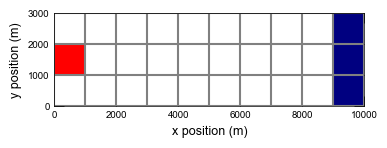

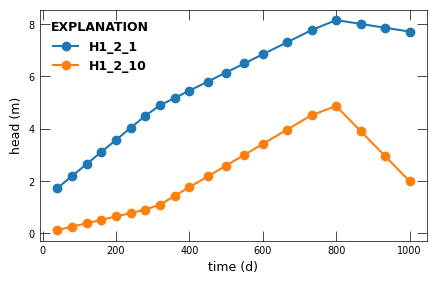

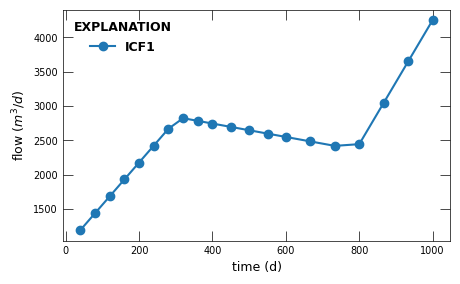

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()